# Environment Setup

In [ ]:
!rm -rf nltk_data >/dev/null 2>&1
!rm -rf /root/nltk_data/ >/dev/null 2>&1
!mkdir -p /root/nltk_data/
!git clone https://github.com/nltk/nltk_data.git >/dev/null 2>&1
!mv nltk_data/packages/* /root/nltk_data/ >/dev/null 2>&1

In [ ]:
%cd /root/nltk_data/tokenizers/
!unzip punkt.zip >/dev/null 2>&1
!rm punkt.zip >/dev/null 2>&1

/root/nltk_data/tokenizers


In [ ]:
%cd /content/
!rm -rf CoAuthorViz* >/dev/null 2>&1
!rm -rf coauthor-v1.0 >/dev/null 2>&1
!rm -rf chi2022-coauthor-v1.0.zip >/dev/null 2>&1
!rm -rf *.py >/dev/null 2>&1
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TsXaUaupZ3XX4uWOWW1PwpZsmgGQ0HYD' \
    -O 'CoAuthorViz.zip' >/dev/null 2>&1
!unzip CoAuthorViz.zip >/dev/null 2>&1
!cp CoAuthorViz/scripts/*.py .
!cp CoAuthorViz/csv/taaco_results.csv .
!sh CoAuthorViz/download_dataset.sh >/dev/null 2>&1

/content


# Import Libraries

In [ ]:
from tqdm import tqdm
import pandas as pd
import nltk
from nltk import word_tokenize
import string
import numpy as np

from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import wilcoxon

import matplotlib.pyplot as plt

from utils import load_sessions, read_session
from main import generate_buffer
from events import generate_event_seq
from summary import stats

# Compute summary statistics

In [ ]:
sessions = load_sessions()
# sessions = load_sessions()[:10]

file_name = []
text = []
sentence_metrics_list = []
api_metrics_list = []

err = []

for sess in tqdm(sessions):
    events = read_session(sess, verbose=0)
    try:
        text_buffer = generate_buffer(events)
    except:
        err.append(str(sess.split('/')[-1]) + " is throwing an error!")
        continue
    file_name.append(sess.split('/')[-1])
    text.append(text_buffer[-1])
    event_seq_dict = generate_event_seq(buffer=text_buffer,
                                        events=events)
    sentence_metrics, api_metrics = stats(event_seq_dict)
    sentence_metrics_list.append(sentence_metrics)
    api_metrics_list.append(api_metrics)
    
for e in err:
    print(e)
    
df = pd.DataFrame()

df["file_name"] = file_name
df["text"] = text

for col in sentence_metrics_list[0]:
    df[str(col)] = [x[col] for x in sentence_metrics_list]
    
for col in api_metrics_list[0]:
    df[str(col)] = [x[col] for x in api_metrics_list]

Successfully downloaded 1447 writing sessions in CoAuthor!


 22%|██▏       | 315/1447 [04:59<15:10,  1.24it/s]/content/events.py:171: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "prompt" in temp_dict["sequence"][idx]:
/content/summary.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ("gpt3-call" not in seq) and ("prompt" not in seq) and ("user" in seq):
/content/summary.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ("gpt3-call" in seq) and ("user" not in seq):
100%|██████████| 1447/1447 [21:33<00:00,  1.12it/s]

312e3263a9f24f3184364949a42a6dfc.jsonl is throwing an error!


# Ratios

In [1]:
def get_ratio(num1, num2):
    return float(num1 / num2)


def add(num1, num2):
    return num1 + num2

In [ ]:
# GPT-3 : Total Sentences

df["GPT-3 : Total Sentences"] = list(map(get_ratio, 
    df["Number of sentences completely authored by GPT-3"], 
    df["Total number of sentences"]
))

df["GPT-3 : Total Sentences"]

0       0.000000
1       0.000000
2       0.055556
3       0.000000
4       0.000000
          ...   
1441    0.000000
1442    0.000000
1443    0.000000
1444    0.000000
1445    0.000000
Name: GPT-3 : Total Sentences, Length: 1446, dtype: float64

In [ ]:
# User : Total Sentences

df["User : Total Sentences"] = list(map(get_ratio, 
    df["Number of sentences completely authored by the user"], 
    df["Total number of sentences"]
))

df["User : Total Sentences"]

0       0.741935
1       0.833333
2       0.333333
3       0.600000
4       0.785714
          ...   
1441    0.400000
1442    0.666667
1443    0.545455
1444    0.742857
1445    0.437500
Name: User : Total Sentences, Length: 1446, dtype: float64

In [ ]:
# Amount of usage of GPT-3 (SD+SE/SA)

df["Amount of GTP-3 Usage"] = list(map(get_ratio, 
    pd.Series(list(map(add, df["Number of sentences authored by GPT-3 and user"], 
                       df["Number of sentences completely authored by GPT-3"]))), 
    df["Total number of sentences"]
))

df["Amount of GTP-3 Usage"]

0       0.064516
1       0.055556
2       0.333333
3       0.050000
4       0.107143
          ...   
1441    0.200000
1442    0.000000
1443    0.181818
1444    0.200000
1445    0.125000
Name: Amount of GTP-3 Usage, Length: 1446, dtype: float64

In [ ]:
# Type Token Ratio

def get_ttr(text):
    sentence_tokens = word_tokenize(text)
    punctuations = list(string.punctuation)
    sentence_tokens_clean = [word for word in sentence_tokens if word not in punctuations]
    ttr = len(set(sentence_tokens_clean)) / len(sentence_tokens_clean)
    return ttr


df["Type Token Ratio"] = df["text"].apply(get_ttr)
df["Type Token Ratio"]

0       0.563758
1       0.409002
2       0.529586
3       0.520833
4       0.548193
          ...   
1441    0.564103
1442    0.424427
1443    0.495775
1444    0.459615
1445    0.506849
Name: Type Token Ratio, Length: 1446, dtype: float64

# View DataFrame

In [ ]:
df.head()

,file_name,text,Total number of sentences,Number of sentences of initial prompt,Number of sentences completely authored by the user,Number of sentences completely authored by GPT-3,Number of sentences authored by GPT-3 and user,Total number of GPT-3 calls made,Number of times GPT-3 suggestion is used,Number of times user rejected GPT-3 suggestion,Number of times GPT-3 suggestion is modified,Number of times GPT-3 suggestion is used as is,GPT-3 : Total Sentences,User : Total Sentences,Amount of GTP-3 Usage,Type Token Ratio
0,8be576f5a9fc4388bb4a608282382fa3.jsonl,Once upon a time there was an old mother pig w...,31,6,23,0,2,6,2,4,2,0,0.000000,0.741935,0.064516,0.563758
1,734cbb77f63544e5bce5a23f35c9f601.jsonl,"Your entire life, you've been told you're deat...",36,4,30,0,2,2,2,0,1,1,0.000000,0.833333,0.055556,0.409002
2,e06104f363824cd3b6c204c905c47f71.jsonl,How Worried Should We Be About Screen Time Dur...,18,6,6,1,5,10,6,4,1,5,0.055556,0.333333,0.333333,0.529586
3,4022d8e5d974472d92c889c74e7fea9b.jsonl,Should Schools Provide Free Pads and Tampons?\...,20,7,12,0,1,8,1,7,1,0,0.000000,0.600000,0.050000,0.520833
4,6e8295cfe7b7425198f0d305a29e3fc3.jsonl,"When you're 28, science discovers a drug that ...",28,3,22,0,3,12,3,9,0,3,0.000000,0.785714,0.107143,0.548193


# Export to CSV

In [ ]:
df.to_csv("coauthorviz_metrics.csv")

# Read from CSV

In [ ]:
df = pd.read_csv("coauthorviz_metrics.csv").drop("Unnamed: 0", axis=1)
df.head()

,file_name,text,Total number of sentences,Number of sentences of initial prompt,Number of sentences completely authored by the user,Number of sentences completely authored by GPT-3,Number of sentences authored by GPT-3 and user,Total number of GPT-3 calls made,Number of times GPT-3 suggestion is used,Number of times user rejected GPT-3 suggestion,Number of times GPT-3 suggestion is modified,Number of times GPT-3 suggestion is used as is,GPT-3 : Total Sentences,User : Total Sentences,Amount of GTP-3 Usage,Type Token Ratio
0,8be576f5a9fc4388bb4a608282382fa3.jsonl,Once upon a time there was an old mother pig w...,31,6,23,0,2,6,2,4,2,0,0.000000,0.741935,0.064516,0.563758
1,734cbb77f63544e5bce5a23f35c9f601.jsonl,"Your entire life, you've been told you're deat...",36,4,30,0,2,2,2,0,1,1,0.000000,0.833333,0.055556,0.409002
2,e06104f363824cd3b6c204c905c47f71.jsonl,How Worried Should We Be About Screen Time Dur...,18,6,6,1,5,10,6,4,1,5,0.055556,0.333333,0.333333,0.529586
3,4022d8e5d974472d92c889c74e7fea9b.jsonl,Should Schools Provide Free Pads and Tampons?\...,20,7,12,0,1,8,1,7,1,0,0.000000,0.600000,0.050000,0.520833
4,6e8295cfe7b7425198f0d305a29e3fc3.jsonl,"When you're 28, science discovers a drug that ...",28,3,22,0,3,12,3,9,0,3,0.000000,0.785714,0.107143,0.548193


# Write Sentences to Text Files

In [ ]:
# for file_name, text in zip(df["file_name"], df["text"]):
#     file_name = file_name.split('.')[0] # Extract only the name and not the 'jsonl' part
#     file_name = "taaco-input-texts/" + file_name + ".txt"
#     with open(file_name, "w") as f:
#         f.write(text)

# Read TAACO Metrics CSV

In [ ]:
taaco_df = pd.read_csv("taaco_results.csv")
taaco_df.head()

,Filename,lemma_ttr,lemma_mattr,lexical_density_tokens,lexical_density_types,content_ttr,function_ttr,function_mattr,noun_ttr,verb_ttr,...,negative_logical,all_temporal,positive_intentional,all_positive,all_negative,all_connective,pronoun_density,pronoun_noun_ratio,repeated_content_lemmas,repeated_content_and_pronoun_lemmas
0,007769c9000e457eae8485221041802d.txt,0.378713,0.683549,0.475248,0.751634,0.598958,0.202830,0.405276,0.790698,0.500000,...,0.014851,0.014851,0.012376,0.061881,0.014851,0.066832,0.215347,2.023256,0.287129,0.502475
1,00bf170a815a42359f3aef35f5674ddc.txt,0.471850,0.803765,0.541555,0.750000,0.653465,0.280702,0.522951,0.650000,0.603448,...,0.002681,0.008043,0.000000,0.037534,0.008043,0.034853,0.056300,0.210000,0.262735,0.313673
2,00d39011efcb4533ab12076801f74f42.txt,0.326816,0.638641,0.444134,0.717949,0.528302,0.180905,0.402133,0.450000,0.587302,...,0.011173,0.016760,0.002793,0.053073,0.011173,0.067039,0.148045,0.883333,0.301676,0.444134
3,0139e814be15409dbab46c2d2d9ca07f.txt,0.422131,0.753075,0.508197,0.762136,0.633065,0.229167,0.473822,0.637168,0.571429,...,0.004098,0.010246,0.010246,0.079918,0.010246,0.067623,0.131148,0.566372,0.272541,0.401639
4,01650a401e614c38a04a904165a5784f.txt,0.503571,0.715758,0.478571,0.709220,0.746269,0.294521,0.433196,0.761905,0.666667,...,0.007143,0.010714,0.000000,0.053571,0.007143,0.046429,0.028571,0.126984,0.189286,0.196429


# Append TAACO Metrics to Original DataFrame 

In [ ]:
taaco_df["file_name"] = taaco_df["Filename"].apply(lambda x: x.split(".")[0])
taaco_df.drop(["Filename"], inplace=True, axis=1)

In [ ]:
new_df = df
new_df["file_name"] = new_df["file_name"].apply(lambda x: x.split(".")[0])

In [ ]:
new_df = pd.merge(new_df, taaco_df, on="file_name")
new_df.to_csv("all_metrics.csv")
new_df.head()

,file_name,text,Total number of sentences,Number of sentences of initial prompt,Number of sentences completely authored by the user,Number of sentences completely authored by GPT-3,Number of sentences authored by GPT-3 and user,Total number of GPT-3 calls made,Number of times GPT-3 suggestion is used,Number of times user rejected GPT-3 suggestion,...,negative_logical,all_temporal,positive_intentional,all_positive,all_negative,all_connective,pronoun_density,pronoun_noun_ratio,repeated_content_lemmas,repeated_content_and_pronoun_lemmas
0,8be576f5a9fc4388bb4a608282382fa3,Once upon a time there was an old mother pig w...,31,6,23,0,2,6,2,4,...,0.003344,0.006689,0.000000,0.046823,0.003344,0.036789,0.053512,0.253968,0.277592,0.324415
1,734cbb77f63544e5bce5a23f35c9f601,"Your entire life, you've been told you're deat...",36,4,30,0,2,2,2,0,...,0.005871,0.003914,0.003914,0.046967,0.007828,0.054795,0.056751,0.298969,0.309198,0.365949
2,e06104f363824cd3b6c204c905c47f71,How Worried Should We Be About Screen Time Dur...,18,6,6,1,5,10,6,4,...,0.008902,0.029674,0.002967,0.083086,0.011869,0.103858,0.041543,0.225806,0.317507,0.356083
3,4022d8e5d974472d92c889c74e7fea9b,Should Schools Provide Free Pads and Tampons?\...,20,7,12,0,1,8,1,7,...,0.005952,0.014881,0.014881,0.104167,0.011905,0.107143,0.065476,0.258824,0.312500,0.375000
4,6e8295cfe7b7425198f0d305a29e3fc3,"When you're 28, science discovers a drug that ...",28,3,22,0,3,12,3,9,...,0.015060,0.024096,0.009036,0.060241,0.018072,0.057229,0.111446,0.725490,0.286145,0.388554


# Divide into High-usage and Low-usage Groups

In [ ]:
print("Median of Amount of GPT-3 Usage:", np.median(new_df["Amount of GTP-3 Usage"]))

Median of Amount of GPT-3 Usage: 0.25


In [ ]:
df_high = new_df[new_df["Amount of GTP-3 Usage"] > np.median(new_df["Amount of GTP-3 Usage"])]
print("Number of writing sessions with high GPT-3 usage:", len(df_high))

Number of writing sessions with high GPT-3 usage: 711


In [ ]:
df_low = new_df[new_df["Amount of GTP-3 Usage"] <= np.median(new_df["Amount of GTP-3 Usage"])]
print("Number of writing sessions with low GPT-3 usage:", len(df_low))

Number of writing sessions with low GPT-3 usage: 735


# Print High-usage Group Metrics

In [ ]:
for col in df_high.columns:
    if col in df.columns:
        continue
    print("Mean", col, ":", np.mean(df_high[col]))

Mean lemma_ttr : 0.39566517342276647
Mean lemma_mattr : 0.7179749880234613
Mean lexical_density_tokens : 0.492493194927315
Mean lexical_density_types : 0.7298605842671576
Mean content_ttr : 0.5861735414269972
Mean function_ttr : 0.22927891606080378
Mean function_mattr : 0.45945612558868354
Mean noun_ttr : 0.5714413683308678
Mean verb_ttr : 0.5783751312926202
Mean adj_ttr : 0.7461656748764106
Mean adv_ttr : 0.6497700219972545
Mean prp_ttr : 0.17657296806605402
Mean argument_ttr : 0.429123983339339
Mean bigram_lemma_ttr : 0.8234015466743136
Mean trigram_lemma_ttr : 0.9370020817332392
Mean adjacent_overlap_all_sent : 0.22125910890738962
Mean adjacent_overlap_all_sent_div_seg : 3.0957592984301026
Mean adjacent_overlap_binary_all_sent : 0.8557983463264599
Mean adjacent_overlap_2_all_sent : 0.3258361102023755
Mean adjacent_overlap_2_all_sent_div_seg : 4.524952284216737
Mean adjacent_overlap_binary_2_all_sent : 0.932773742784751
Mean adjacent_overlap_cw_sent : 0.11790627962228004
Mean adjacen

# Print Low-usage Group Metrics

In [ ]:
for col in df_low.columns:
    if col in df.columns:
        continue
    print("Mean", col, ":", np.mean(df_low[col]))

Mean lemma_ttr : 0.4067844294338326
Mean lemma_mattr : 0.7359486170817755
Mean lexical_density_tokens : 0.4986869364836476
Mean lexical_density_types : 0.724942728571826
Mean content_ttr : 0.5916782509561904
Mean function_ttr : 0.24324487610879186
Mean function_mattr : 0.48161411607088844
Mean noun_ttr : 0.5831814693950435
Mean verb_ttr : 0.5758111065608422
Mean adj_ttr : 0.7479120982481169
Mean adv_ttr : 0.6522506582306462
Mean prp_ttr : 0.1800524034218611
Mean argument_ttr : 0.43990432994044215
Mean bigram_lemma_ttr : 0.8513107784172912
Mean trigram_lemma_ttr : 0.9551831299437388
Mean adjacent_overlap_all_sent : 0.20330811773115934
Mean adjacent_overlap_all_sent_div_seg : 2.7921811799257985
Mean adjacent_overlap_binary_all_sent : 0.836492306545453
Mean adjacent_overlap_2_all_sent : 0.30335939640455234
Mean adjacent_overlap_2_all_sent_div_seg : 4.132163259174423
Mean adjacent_overlap_binary_2_all_sent : 0.9182072478099128
Mean adjacent_overlap_cw_sent : 0.10748781410084925
Mean adjace

# Generate Mean, Median and Standard Deviation for all Metrics

In [ ]:
all_metrics_stats_df = pd.DataFrame()

metrics = []
mean = []
median = []
std = []
minimum = []
maximum = []

for col in new_df.columns:
    if col in ["file_name", "text"]: continue
    metrics.append(col)
    mean.append(np.mean(new_df[col]))
    median.append(np.median(new_df[col]))
    std.append(np.std(new_df[col]))
    minimum.append(np.min(new_df[col]))
    maximum.append(np.max(new_df[col]))

all_metrics_stats_df["Metrics"] = metrics
all_metrics_stats_df["Mean"] = mean
all_metrics_stats_df["Median"] = median
all_metrics_stats_df["Standard Deviation"] = std
all_metrics_stats_df["Minimum"] = minimum
all_metrics_stats_df["Maximum"] = maximum

all_metrics_stats_df.to_csv("all_metric_stats.csv")
all_metrics_stats_df

,Metrics,Mean,Median,Standard Deviation,Minimum,Maximum
0,Total number of sentences,28.958506,27.000000,10.386497,11.000000,78.000000
1,Number of sentences of initial prompt,4.421162,4.000000,2.390986,0.000000,9.000000
2,Number of sentences completely authored by the...,16.262794,15.000000,9.545122,0.000000,64.000000
3,Number of sentences completely authored by GPT-3,0.674965,0.000000,1.864206,0.000000,22.000000
4,Number of sentences authored by GPT-3 and user,7.599585,6.000000,5.952855,0.000000,42.000000
...,...,...,...,...,...,...
165,all_connective,0.068503,0.067545,0.017166,0.017182,0.131078
166,pronoun_density,0.068835,0.062363,0.032258,0.008086,0.224000
167,pronoun_noun_ratio,0.355129,0.300000,0.230119,0.031250,2.023256
168,repeated_content_lemmas,0.287767,0.290206,0.045190,0.138996,0.436620


# T-Test

In [ ]:
t_test_df = pd.DataFrame()

t_stat = []
p_val = []
metrics = []

mean_low_group = []
mean_high_group = []

std_low_group = []
std_high_group = []

ALPHA = 0.05

for col in new_df.columns:
    if col in df.columns:
        continue
    metrics.append(col)
    t_stat_result, p_val_result = ttest_ind(df_low[col], df_high[col], equal_var=True)
    t_stat.append(t_stat_result)
    p_val.append(p_val_result)
    mean_low_group.append(np.mean(df_low[col]))
    mean_high_group.append(np.mean(df_high[col]))
    std_low_group.append(np.std(df_low[col]))
    std_high_group.append(np.std(df_high[col]))

degree_of_freedom = len(df_low) + len(df_high) - 2
    
t_test_df["Metric"] = metrics
t_test_df["Mean (High Group)"] = mean_high_group
t_test_df["Mean (Low Group)"] = mean_low_group
t_test_df["STD (High Group)"] = std_high_group
t_test_df["STD (Low Group)"] = std_low_group
t_test_df["T-Statistic (df=" + str(degree_of_freedom) + ")"] = t_stat
t_test_df["P-Value"] = p_val
t_test_df["Verdict (alpha=" + str(ALPHA) + ")"] = t_test_df["P-Value"].apply(lambda x:
    "Means of both groups are same" if x > ALPHA else "Means of both groups are different")

t_test_df.to_csv("t_test_results.csv")
t_test_df.head()

,Metric,Mean (High Group),Mean (Low Group),STD (High Group),STD (Low Group),T-Statistic (df=1444),P-Value,Verdict (alpha=0.05)
0,lemma_ttr,0.395665,0.406784,0.056473,0.052727,3.868746,1.142675e-04,Means of both groups are different
1,lemma_mattr,0.717975,0.735949,0.042395,0.034264,8.874159,2.039112e-18,Means of both groups are different
2,lexical_density_tokens,0.492493,0.498687,0.040063,0.036324,3.079594,2.111932e-03,Means of both groups are different
3,lexical_density_types,0.729861,0.724943,0.039201,0.035609,-2.496804,1.264251e-02,Means of both groups are different
4,content_ttr,0.586174,0.591678,0.074166,0.072873,1.422563,1.550789e-01,Means of both groups are same


# Check if the Groups are normally distributed using Shapiro-Wilk Test

In [ ]:
shapiro_df = pd.DataFrame()

stat_low = []
stat_high = []
p_val_low = []
p_val_high = []
metrics = []

ALPHA = 0.05

for col in new_df.columns:
    if col in df.columns:
        continue
    metrics.append(col)
    stat_result_low, p_val_result_low = shapiro(df_high[col])
    stat_low.append(stat_result_low)
    p_val_low.append(p_val_result_low)
    stat_result_high, p_val_result_high = shapiro(df_high[col])
    stat_high.append(stat_result_high)
    p_val_high.append(p_val_result_high)
    
shapiro_df["Metric"] = metrics

shapiro_df["Statistic (High Group)"] = stat_high
shapiro_df["P-Value (High Group)"] = p_val_high
shapiro_df["Distribution (High Group)"] = shapiro_df["P-Value (High Group)"].apply(
    lambda x: "Normal" if x > ALPHA else "Not Normal")

shapiro_df["Statistic (Low Group)"] = stat_low
shapiro_df["P-Value (Low Group)"] = p_val_low
shapiro_df["Distribution (Low Group)"] = shapiro_df["P-Value (Low Group)"].apply(
    lambda x: "Normal" if x > ALPHA else "Not Normal")

shapiro_df.to_csv("shapiro_wilk_test_results.csv")
shapiro_df.head()

,Metric,Statistic (High Group),P-Value (High Group),Distribution (High Group),Statistic (Low Group),P-Value (Low Group),Distribution (Low Group)
0,lemma_ttr,0.998438,0.786461,Normal,0.998438,0.786461,Normal
1,lemma_mattr,0.990763,0.000196,Not Normal,0.990763,0.000196,Not Normal
2,lexical_density_tokens,0.996558,0.128131,Normal,0.996558,0.128131,Normal
3,lexical_density_types,0.987020,0.000006,Not Normal,0.987020,0.000006,Not Normal
4,content_ttr,0.999325,0.997753,Normal,0.999325,0.997753,Normal


In [ ]:
req_metrics = ["lemma_ttr", "adjacent_overlap_all_sent", "adjacent_overlap_all_para",
    "lsa_1_all_sent", "lsa_1_all_para", "all_connective"]

shapiro_df[shapiro_df["Metric"].isin(req_metrics)].head()

,Metric,Statistic (High Group),P-Value (High Group),Distribution (High Group),Statistic (Low Group),P-Value (Low Group),Distribution (Low Group)
0,lemma_ttr,0.998438,7.864609e-01,Normal,0.998438,7.864609e-01,Normal
15,adjacent_overlap_all_sent,0.986378,3.504494e-06,Not Normal,0.986378,3.504494e-06,Not Normal
69,adjacent_overlap_all_para,0.939513,2.095681e-16,Not Normal,0.939513,2.095681e-16,Not Normal
123,lsa_1_all_sent,0.990194,1.116431e-04,Not Normal,0.990194,1.116431e-04,Not Normal
125,lsa_1_all_para,0.982521,1.679408e-07,Not Normal,0.982521,1.679408e-07,Not Normal


# Generate Box Plot

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


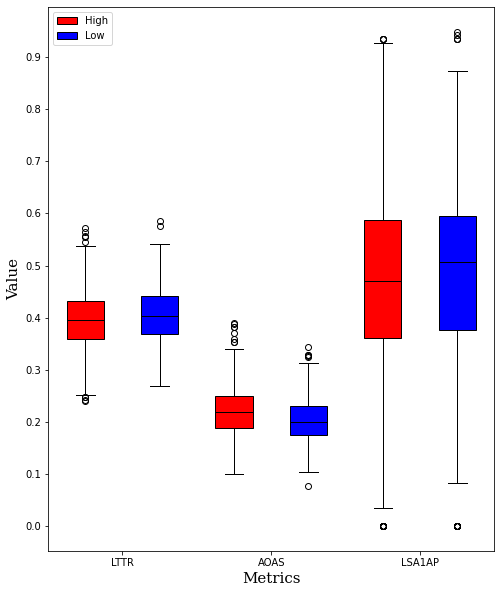

In [ ]:
fig1, ax1 = plt.subplots(figsize=(8,10))
data = [
    df_high["lemma_ttr"], df_low["lemma_ttr"], 
    df_high["adjacent_overlap_all_sent"], df_low["adjacent_overlap_all_sent"],
    df_high["lsa_1_all_para"], df_low["lsa_1_all_para"],
]
box1 = ax1.boxplot(data, patch_artist=True)

plt.setp(box1["boxes"][0], facecolor="red")
plt.setp(box1["boxes"][1], facecolor="blue")

plt.setp(box1["boxes"][2], facecolor="red")
plt.setp(box1["boxes"][3], facecolor="blue")

plt.setp(box1["boxes"][4], facecolor="red")
plt.setp(box1["boxes"][5], facecolor="blue")

for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(box1[element], color="black")

ax1.legend([box1["boxes"][0], box1["boxes"][1]], ['High', 'Low'])

# ax1.set_title('Grouped Box Plot', fontdict={"family": "serif", "size": "20"})
ax1.set_xlabel('Metrics', fontdict={"family": "serif", "size": "15"})
ax1.set_ylabel('Value', fontdict={"family": "serif", "size": "15"})

plt.xticks([1.5, 3.5, 5.5], ['LTTR', 'AOAS', 'LSA1AP'])
plt.yticks(np.arange(0, 1, 0.1))

plt.savefig("boxplot.png")
plt.show()